# Churn Prediction EDA

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# se importa dataset y se eliminan columnas sin datos
df = pd.read_csv('churn_prediction_features.csv').drop(columns=['KVI_gmv_percent', 'FORE_gmv_percent', 'LONG_gmv_percent', 'NO_CLASS_gmv_percent'])

determinando cuáles son columnas numéricas y categóricas

In [3]:
# categorical columns: the ones that start with 'sub_categoria_' or 'warehouse_'
categorical_cols = [col for col in df.columns if col.startswith('sub_categoria_') or col.startswith('warehouse_')]
# manually including more categorical columns to the list
categorical_cols.extend(['customer_id', 'has_churned_before', 'is_churned'])

# numerical columns
numerical_cols = [col for col in df.columns if col not in categorical_cols]

## Reducción de dimensionalidad

### variables categóricas

se verifica entonces la dimensión del dataframe de variables categóricas

In [4]:
df_categoricals = df[categorical_cols].drop(columns=['customer_id'], axis = 1)

df_categoricals.shape

(5293, 83)

se tienen 83 columnas categóricas, se procede a hacer pruebas de independencia de variables categóricas

#### verificando supuestos de la prueba chi cuadrado

uno de los supuestos indica que debe haber almenos cinco ocurrencias de cada clase para cada variable categórica, por lo cuál procede a verificarse este supuesto

In [5]:
# Create an empty dataframe to store value counts
value_counts_df = pd.DataFrame(index=['negative_class', 'positive_class'])

# Loop through each categorical column and get value counts
for column in df_categoricals.columns:
    value_counts = df_categoricals[column].value_counts().values
    value_counts_df[column] = value_counts

# Display the resulting dataframe
value_counts_df.T

,negative_class,positive_class
sub_categoria_Accesorios,5111,180
sub_categoria_Acondicionador,4434,857
sub_categoria_Ambientadores,5271,20
sub_categoria_Analgésicos,4646,645
sub_categoria_Antibióticos y analgésicos,5012,279
...,...,...
sub_categoria_sin info,3942,1349
warehouse_Barranquilla,3543,1748
warehouse_Bogota,3568,1723
has_churned_before,3575,1718


categorías con menos de 5 registros en la clase negativa:

In [6]:
value_counts_df.T[value_counts_df.T['negative_class'] < 5]

,negative_class,positive_class


categorías con menos de 5 registros en la clase positiva:

In [7]:
value_counts_df.T[value_counts_df.T['positive_class'] < 5]

,negative_class,positive_class
sub_categoria_Detergentes y jabones,5290,1


por lo cuál proceden a excluírse estas categorías de la prueba

In [8]:
df_categoricals = df_categoricals.drop(columns=['sub_categoria_Detergentes y jabones'], axis=1)

#### aplicando prueba chi cuadrado

dado que se tienen 83 columnas categóricas, se procede a hacer pruebas chi cuadrado entre todas las posibles combinaciones de columnas categóricas, y se guarda este resultado en un dataframe

In [9]:
# Create an empty dataframe to store p-values
p_values_df = pd.DataFrame(index=df_categoricals.columns, columns=df_categoricals.columns)

# Loop through each pair of categorical columns and perform chi-squared test
for col1 in df_categoricals.columns:
    for col2 in df_categoricals.columns:
        contingency_table = pd.crosstab(df_categoricals[col1], df_categoricals[col2])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values_df.at[col1, col2] = p_value

# Display the resulting p-values dataframe
p_values_df

se empieza a descartar. Iniciando por todas aquellas que son dependientes a warehouse_Bogota (escogida aleatoriamente entre todas las variables)

In [11]:
independent_columns = list(p_values_df[p_values_df['warehouse_Bogota'] > 0.05].index)
independent_columns.extend(['warehouse_Bogota'])

df_independent_variables = df_categoricals[independent_columns]

df_independent_variables

,sub_categoria_Acondicionador,sub_categoria_Ambientadores,sub_categoria_Anticonceptivos,sub_categoria_Complementos y vitaminas,sub_categoria_Cuidado corporal,sub_categoria_Cuidado de los pies,sub_categoria_Cuidado facial,sub_categoria_Gomas,sub_categoria_Naturales,sub_categoria_Productos para rehabilitación,sub_categoria_Proteccion e higiene íntima femenina,warehouse_Bogota
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5288,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
5289,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
5290,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
5291,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


por lo cuál, todas las que quedan son independientes a warehouse_Bogota, se procede a tomar otra columna aleatoria para verificar su independencia con todas las otras y seguir eliminando

In [12]:
# Create an empty dataframe to store p-values
p_values_df = pd.DataFrame(index=df_independent_variables.columns, columns=df_independent_variables.columns)

# Loop through each pair of categorical columns and perform chi-squared test
for col1 in df_independent_variables.columns:
    for col2 in df_independent_variables.columns:
        contingency_table = pd.crosstab(df_independent_variables[col1], df_independent_variables[col2])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values_df.at[col1, col2] = p_value

# Display the resulting p-values dataframe
p_values_df

,sub_categoria_Acondicionador,sub_categoria_Ambientadores,sub_categoria_Anticonceptivos,sub_categoria_Complementos y vitaminas,sub_categoria_Cuidado corporal,sub_categoria_Cuidado de los pies,sub_categoria_Cuidado facial,sub_categoria_Gomas,sub_categoria_Naturales,sub_categoria_Productos para rehabilitación,sub_categoria_Proteccion e higiene íntima femenina,warehouse_Bogota
sub_categoria_Acondicionador,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165402
sub_categoria_Ambientadores,0.000001,0.0,0.024807,0.414167,0.007176,0.000018,0.000031,0.000398,0.000001,1.0,0.000025,0.995062
sub_categoria_Anticonceptivos,0.0,0.024807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155511
sub_categoria_Complementos y vitaminas,0.0,0.414167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115869
sub_categoria_Cuidado corporal,0.0,0.007176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081005
sub_categoria_Cuidado de los pies,0.0,0.000018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126449
sub_categoria_Cuidado facial,0.0,0.000031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343994
sub_categoria_Gomas,0.0,0.000398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.720619
sub_categoria_Naturales,0.0,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968453
sub_categoria_Productos para rehabilitación,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383006


Ahora, se toma la variable 'sub_categoria_Ambientadores', se eliminan las que son dependientes a esta y se repite el proceso hasta que todas las variables categóricas restantes, sean independientes

In [13]:
independent_columns =  list(p_values_df[p_values_df['sub_categoria_Ambientadores'] > 0.05].index)
independent_columns.extend(['sub_categoria_Ambientadores'])

df_independent_variables = df_independent_variables[independent_columns]

# Create an empty dataframe to store p-values
p_values_df = pd.DataFrame(index=df_independent_variables.columns, columns=df_independent_variables.columns)

# Loop through each pair of categorical columns and perform chi-squared test
for col1 in df_independent_variables.columns:
    for col2 in df_independent_variables.columns:
        contingency_table = pd.crosstab(df_independent_variables[col1], df_independent_variables[col2])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values_df.at[col1, col2] = p_value

# Display the resulting p-values dataframe
p_values_df

,sub_categoria_Complementos y vitaminas,sub_categoria_Productos para rehabilitación,warehouse_Bogota,sub_categoria_Ambientadores
sub_categoria_Complementos y vitaminas,0.0,0.0,0.115869,0.414167
sub_categoria_Productos para rehabilitación,0.0,0.0,0.383006,1.0
warehouse_Bogota,0.115869,0.383006,0.0,0.995062
sub_categoria_Ambientadores,0.414167,1.0,0.995062,0.0


In [14]:
independent_columns = list(p_values_df[p_values_df['sub_categoria_Complementos y vitaminas'] > 0.05].index)
independent_columns.extend(['sub_categoria_Complementos y vitaminas'])

df_independent_variables = df_independent_variables[independent_columns]

# Create an empty dataframe to store p-values
p_values_df = pd.DataFrame(index=df_independent_variables.columns, columns=df_independent_variables.columns)

# Loop through each pair of categorical columns and perform chi-squared test
for col1 in df_independent_variables.columns:
    for col2 in df_independent_variables.columns:
        contingency_table = pd.crosstab(df_independent_variables[col1], df_independent_variables[col2])
        _, p_value, _, _ = chi2_contingency(contingency_table)
        p_values_df.at[col1, col2] = p_value

# Display the resulting p-values dataframe
p_values_df

,warehouse_Bogota,sub_categoria_Ambientadores,sub_categoria_Complementos y vitaminas
warehouse_Bogota,0.0,0.995062,0.115869
sub_categoria_Ambientadores,0.995062,0.0,0.414167
sub_categoria_Complementos y vitaminas,0.115869,0.414167,0.0


dado que las tres variables restantes son independientes, se procede a utilizarlas para el modelo

In [15]:
df_categoricals = df_categoricals[['warehouse_Bogota', 'sub_categoria_Ambientadores', 'sub_categoria_Complementos y vitaminas']]

### variables numéricas

examinando correlación

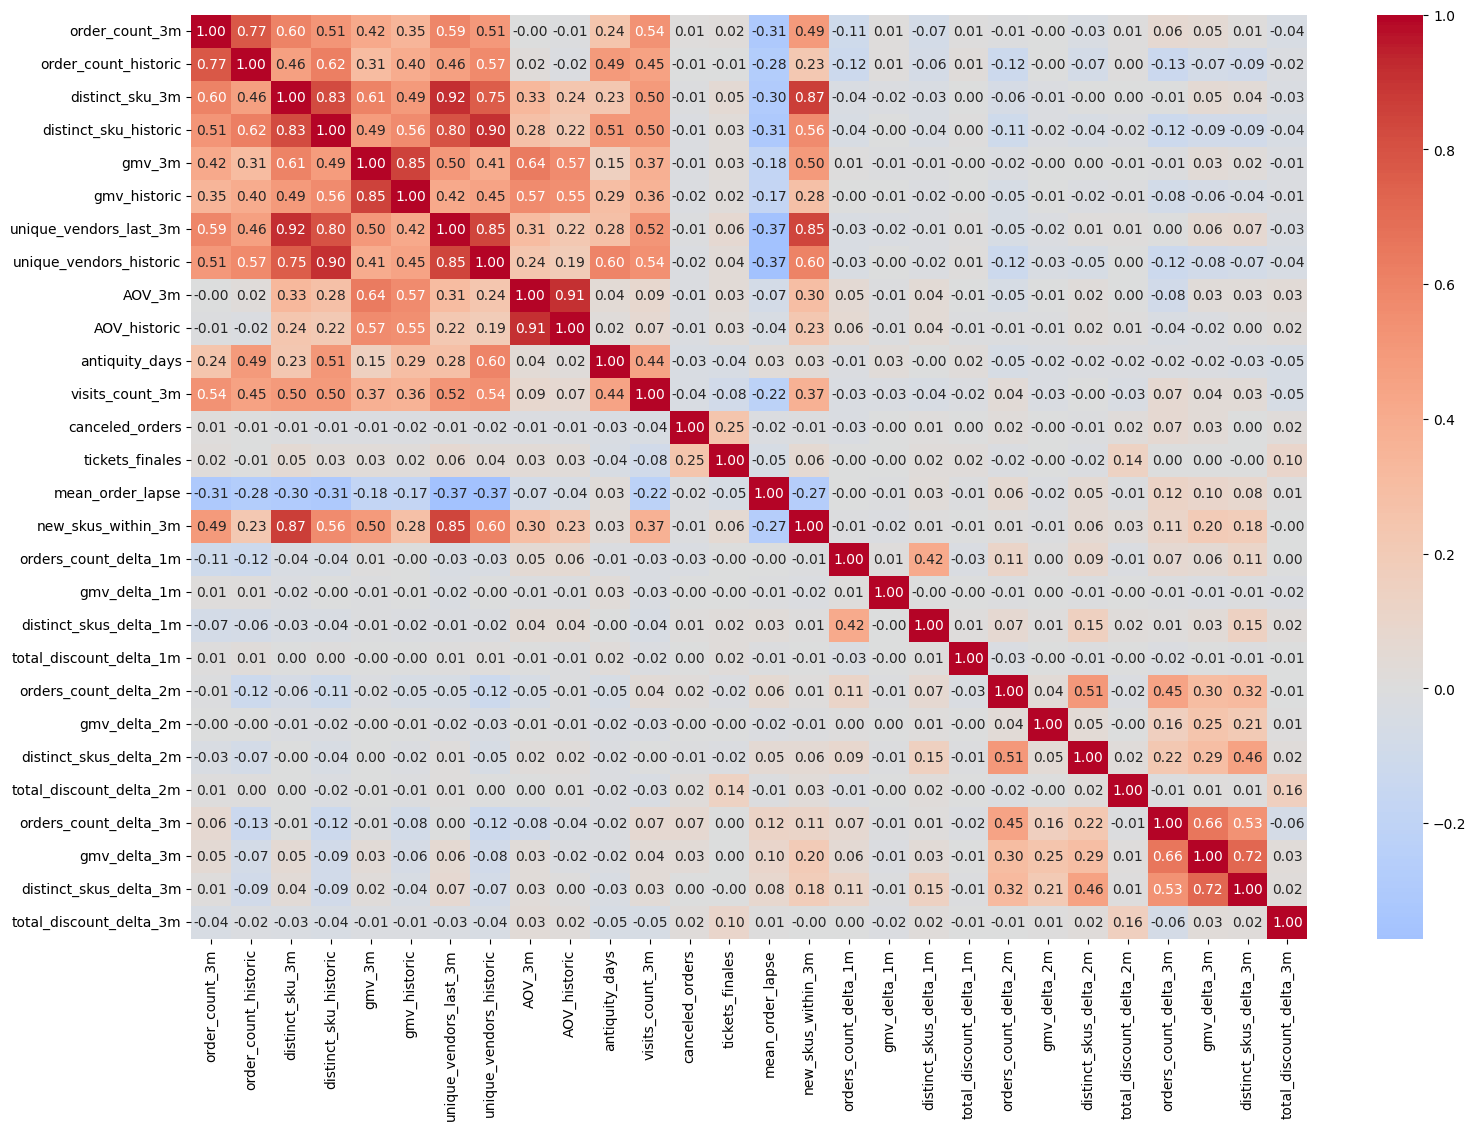

In [16]:
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, center=0, cmap='coolwarm', fmt=".2f")
plt.show()

se evidencian variables con correlaciones muy altas, pero estas se proceden a eliminar con el VIF (Variance Inflation Factor)

### valores nulos

se verifica antes de calcular el VIF, que no hayan valores nulos.

In [17]:
# se toma el dataset con las variables numéricas, más las categóricas independientes, más la variable objetivo
df_reduction = df[numerical_cols + independent_columns].copy()

df_reduction

,order_count_3m,order_count_historic,distinct_sku_3m,distinct_sku_historic,gmv_3m,gmv_historic,unique_vendors_last_3m,unique_vendors_historic,AOV_3m,AOV_historic,...,gmv_delta_2m,distinct_skus_delta_2m,total_discount_delta_2m,orders_count_delta_3m,gmv_delta_3m,distinct_skus_delta_3m,total_discount_delta_3m,warehouse_Bogota,sub_categoria_Ambientadores,sub_categoria_Complementos y vitaminas
0,1,1,8,8,1.503600e+05,1.503600e+05,1,1,1.503600e+05,1.503600e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
1,1,1,5,5,1.127700e+05,1.127700e+05,1,1,1.127700e+05,1.127700e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
2,1,1,4,4,1.452720e+05,1.452720e+05,1,1,1.452720e+05,1.452720e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
3,1,1,11,11,2.014311e+05,2.014311e+05,7,7,2.014311e+05,2.014311e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
4,1,1,6,6,1.612760e+05,1.612760e+05,6,6,1.612760e+05,1.612760e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5288,97,517,270,629,1.769209e+07,7.735332e+07,63,83,1.823927e+05,1.496196e+05,...,0.227910,0.087963,0.127732,0.000000,0.220285,0.084677,0.514818,1.0,0.0,0.0
5289,98,170,968,1377,8.489914e+07,2.313428e+08,111,124,8.663178e+05,1.360840e+06,...,0.461090,0.252427,0.018004,2.769231,0.572470,0.690559,0.054177,1.0,0.0,0.0
5290,100,292,761,1259,1.560360e+08,6.530394e+08,95,112,1.560360e+06,2.236436e+06,...,1.105045,0.457831,0.033094,0.000000,-0.108634,0.006631,0.157169,1.0,0.0,1.0
5291,124,646,263,705,9.956271e+06,4.785726e+07,64,94,8.029251e+04,7.408244e+04,...,-0.113606,-0.153527,0.927276,-0.192547,-0.003659,-0.018116,0.772205,1.0,0.0,1.0


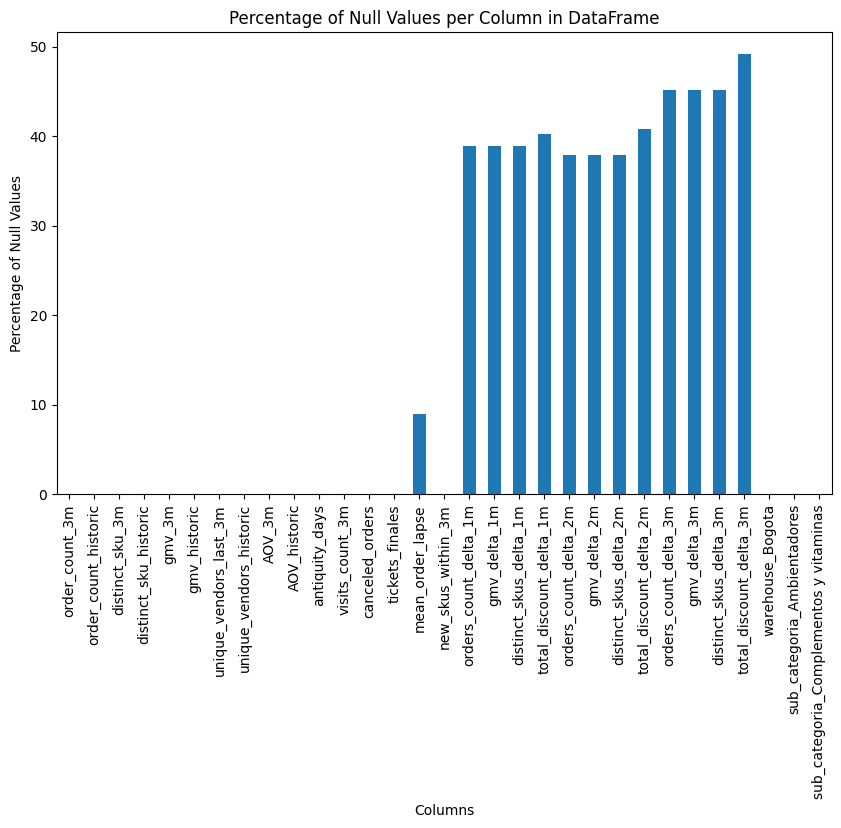

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the percentage of null values
null_percent = df_reduction.isnull().mean() * 100

# Plotting
plt.figure(figsize=(10, 6))
null_percent.plot.bar()
plt.ylabel('Percentage of Null Values')
plt.xlabel('Columns')
plt.title('Percentage of Null Values per Column in DataFrame')
plt.show()

En este caso se eliminan columnas con un 40% o más de valores nulos, y al resto se le imputa la mediana

In [19]:
# Remove columns where 40% or more data is missing
threshold = 0.6 * len(df_reduction)
df_reduction = df_reduction.dropna(thresh=threshold, axis=1)

# calculate the median per column
medians = df_reduction.median()

# Fill missing values with the median of their respective columns
df_reduction = df_reduction.fillna(medians)

df_reduction.isna().sum()

order_count_3m                            0
order_count_historic                      0
distinct_sku_3m                           0
distinct_sku_historic                     0
gmv_3m                                    0
gmv_historic                              0
unique_vendors_last_3m                    0
unique_vendors_historic                   0
AOV_3m                                    0
AOV_historic                              0
antiquity_days                            0
visits_count_3m                           0
canceled_orders                           0
tickets_finales                           0
mean_order_lapse                          0
new_skus_within_3m                        0
orders_count_delta_1m                     0
gmv_delta_1m                              0
distinct_skus_delta_1m                    0
orders_count_delta_2m                     0
gmv_delta_2m                              0
distinct_skus_delta_2m                    0
warehouse_Bogota                

#### Eliminando multicolinealidad con Variance Inflation Factor (VIF)

Recordemos que:

- Un VIF ≥ 5 indica alta multicolinealidad entre la correspondiente variable independiente y las demás variables.

- Recomendación: Eliminar una columna a la vez. Aquella con el máximo VIF ≥ 5. Luego, para el nuevo dataframe, calcular nuevamente VIF e identificar nuevas columnas con VIF ≥ 5 máximo, y así sucesivamente hasta obtener solo valores de VIF < 5.

- Según corresponda, variables categóricas deben previamente codificarse usando por ejemplo OneHotEncoder().

In [20]:
vif_data = pd.DataFrame()
vif_data["Variable"] = df_reduction.columns
vif_data["VIF"] = [variance_inflation_factor(df_reduction.values, i) for i in range(df_reduction.shape[1])]

# Display the result
print(vif_data)

                                  Variable        VIF
0                           order_count_3m   8.670089
1                     order_count_historic   7.090255
2                          distinct_sku_3m  42.717588
3                    distinct_sku_historic  32.538563
4                                   gmv_3m   9.101782
5                             gmv_historic   7.411545
6                   unique_vendors_last_3m  40.458666
7                  unique_vendors_historic  53.781693
8                                   AOV_3m  12.826873
9                             AOV_historic  10.791160
10                          antiquity_days   9.168307
11                         visits_count_3m   3.984999
12                         canceled_orders   1.085857
13                         tickets_finales   1.116103
14                        mean_order_lapse   1.865942
15                      new_skus_within_3m  15.424987
16                   orders_count_delta_1m   1.414609
17                          

se eliminan las columnas con un VIF mayor que 5, eliminando la de mayor VIF en cada iteración

In [21]:
# Assuming df_reduction is your initial DataFrame
while True:
    # Calculating VIF for each variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df_reduction.columns
    vif_data["VIF"] = [variance_inflation_factor(df_reduction.values, i) for i in range(df_reduction.shape[1])]

    # Check if the max VIF is above the threshold (5)
    max_vif = vif_data["VIF"].max()
    if max_vif < 5:
        break

    # Identify the variable/column with the highest VIF
    max_vif_variable = vif_data.sort_values("VIF", ascending=False).iloc[0]
    variable_name = max_vif_variable["Variable"]

    # Print the variable being dropped and its VIF
    print(f"Dropping '{variable_name}' with VIF: {max_vif}")

    # Drop the variable/column from the DataFrame
    df_reduction = df_reduction.drop(columns=[variable_name], axis=1)

Dropping 'unique_vendors_historic' with VIF: 53.781692777473864
Dropping 'distinct_sku_3m' with VIF: 28.152291055047296
Dropping 'unique_vendors_last_3m' with VIF: 19.737012528668085
Dropping 'AOV_3m' with VIF: 11.562062638457881
Dropping 'order_count_3m' with VIF: 7.43386055493348
Dropping 'gmv_3m' with VIF: 6.995457242736988
Dropping 'distinct_sku_historic' with VIF: 6.135113081103419


verificando los resultados finales

In [22]:
vif_data = pd.DataFrame()
vif_data["Variable"] = df_reduction.columns
vif_data["VIF"] = [variance_inflation_factor(df_reduction.values, i) for i in range(df_reduction.shape[1])]

# Display the result
print(vif_data)

                                  Variable       VIF
0                     order_count_historic  2.549589
1                             gmv_historic  2.290194
2                             AOV_historic  2.226552
3                           antiquity_days  4.017303
4                          visits_count_3m  3.508315
5                          canceled_orders  1.084789
6                          tickets_finales  1.103717
7                         mean_order_lapse  1.736261
8                       new_skus_within_3m  2.135510
9                    orders_count_delta_1m  1.410192
10                            gmv_delta_1m  1.002258
11                  distinct_skus_delta_1m  1.319025
12                   orders_count_delta_2m  1.570232
13                            gmv_delta_2m  1.003790
14                  distinct_skus_delta_2m  1.456130
15                        warehouse_Bogota  2.025948
16             sub_categoria_Ambientadores  1.012302
17  sub_categoria_Complementos y vitaminas  1.

por lo cuál el dataframe que será utilizado para entrenar el modelo de clasificación será el siguiente:

In [23]:
df_reduction['is_churned'] = df['is_churned']

df_reduction.head()

,order_count_historic,gmv_historic,AOV_historic,antiquity_days,visits_count_3m,canceled_orders,tickets_finales,mean_order_lapse,new_skus_within_3m,orders_count_delta_1m,gmv_delta_1m,distinct_skus_delta_1m,orders_count_delta_2m,gmv_delta_2m,distinct_skus_delta_2m,warehouse_Bogota,sub_categoria_Ambientadores,sub_categoria_Complementos y vitaminas,is_churned
0,1,150360.000000,150360.000000,0,0,0,0,17.095455,8,0.0,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0,1
1,1,112770.000000,112770.000000,0,0,0,0,17.095455,5,0.0,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0,0
2,1,145272.000000,145272.000000,0,0,0,0,17.095455,4,0.0,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0,1
3,1,201431.050293,201431.050293,0,0,0,0,17.095455,11,0.0,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0,1
4,1,161276.000000,161276.000000,0,0,0,0,17.095455,6,0.0,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0,1


## Variable objetivo

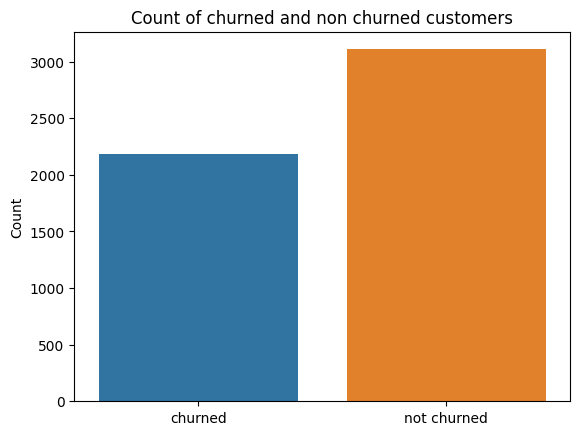

In [24]:
sns.countplot(x=df_reduction['is_churned'].replace({0: 'not churned', 1: 'churned'}))
plt.title(f'Count of churned and non churned customers')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

## variables numericas vs is_churned

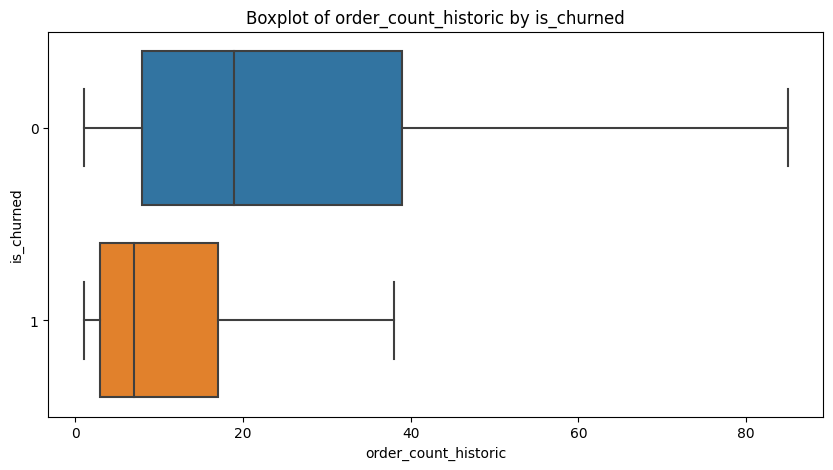

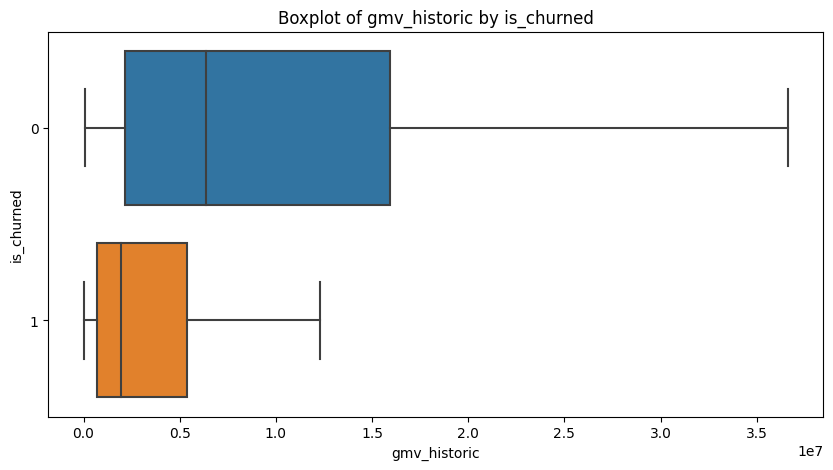

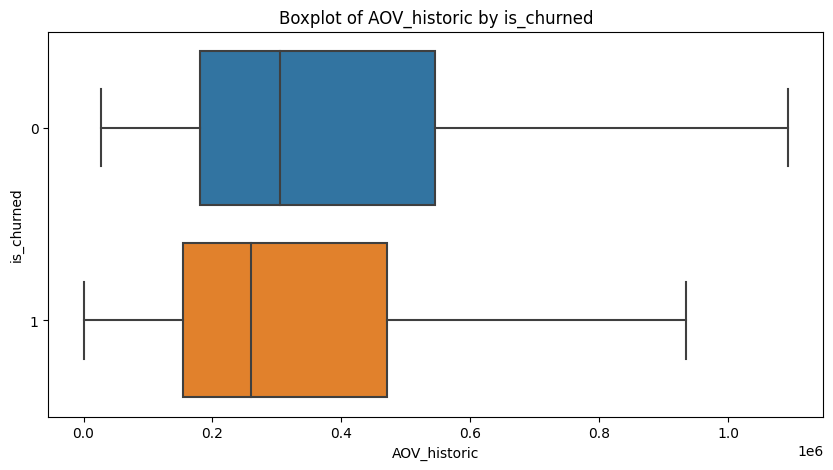

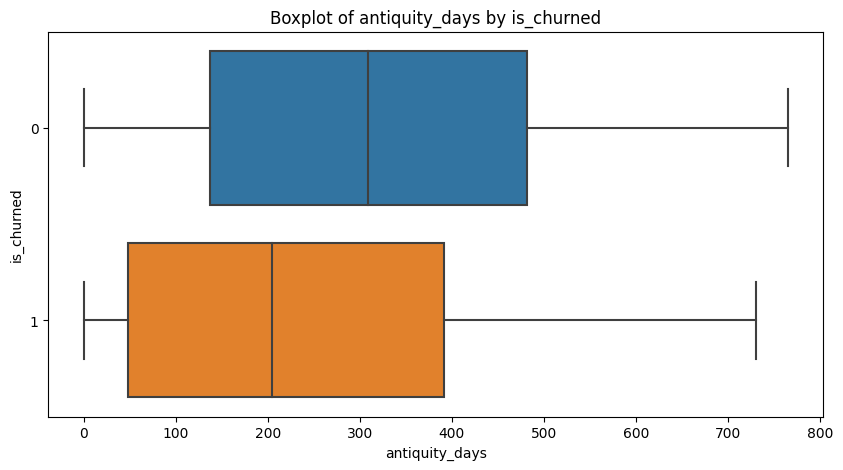

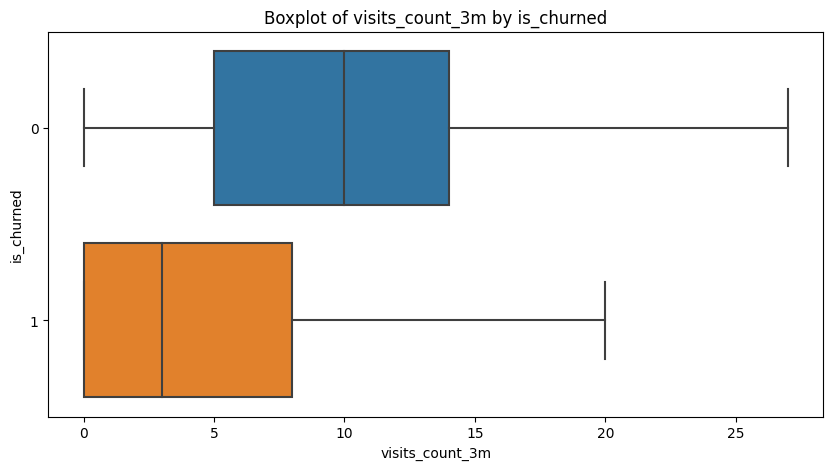

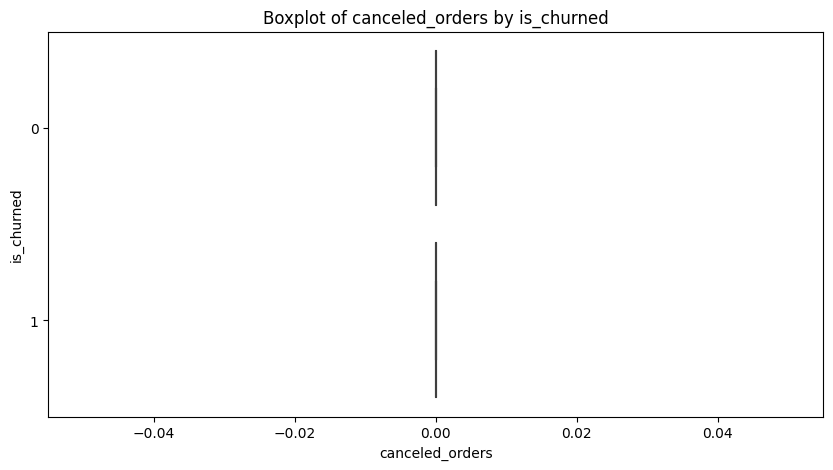

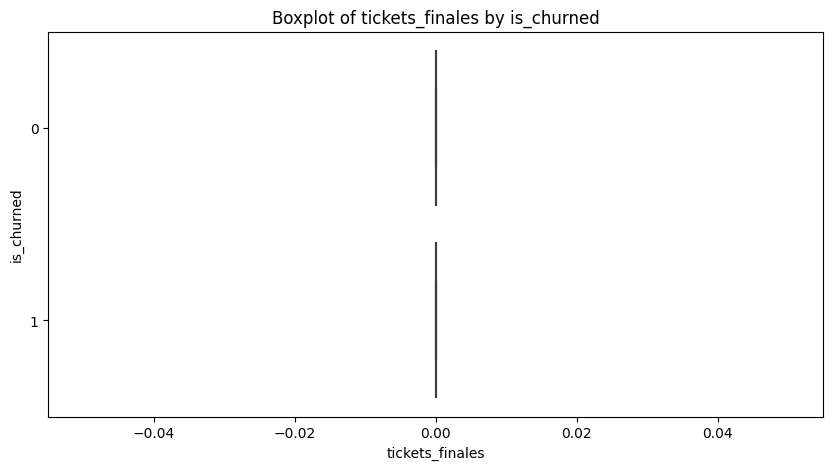

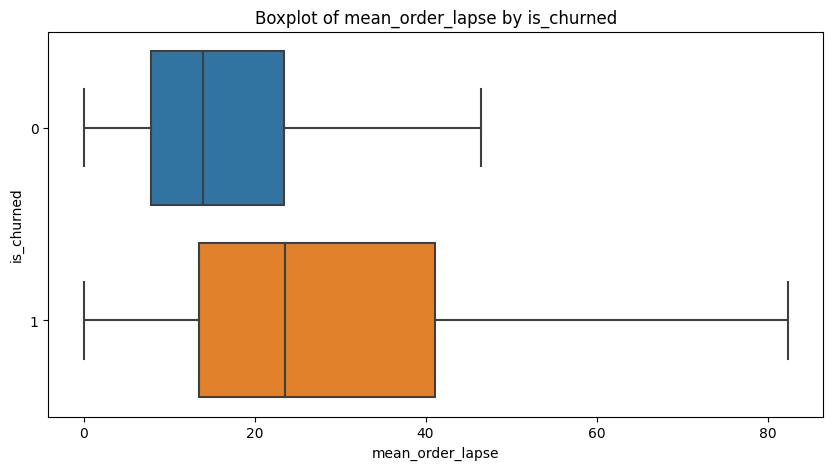

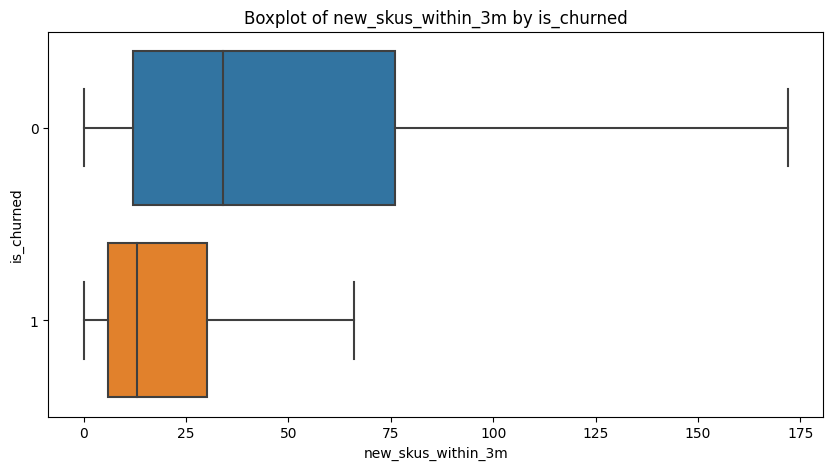

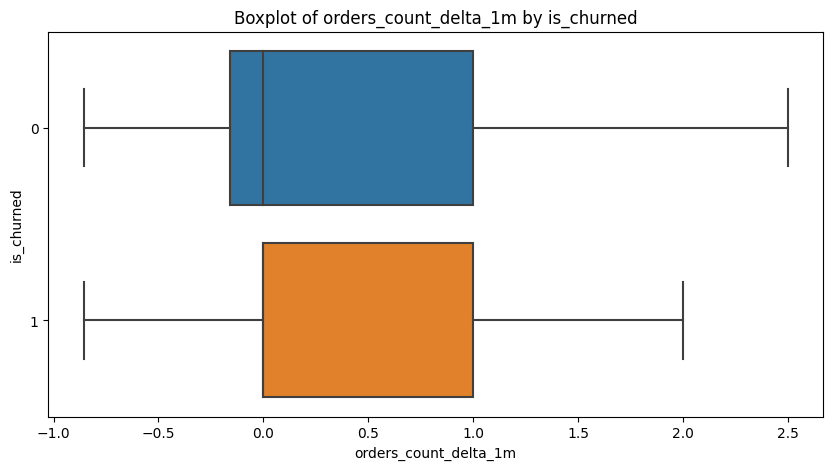

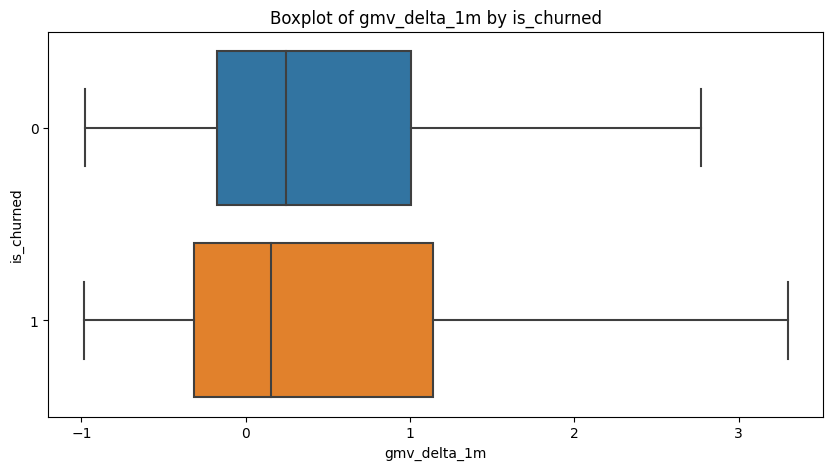

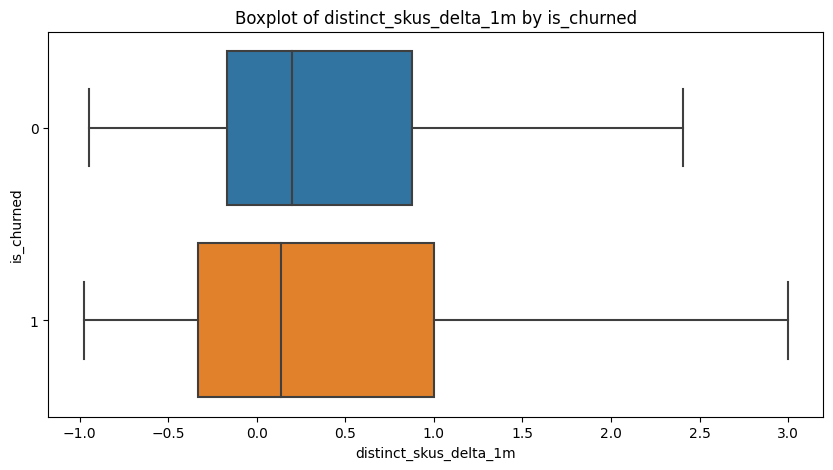

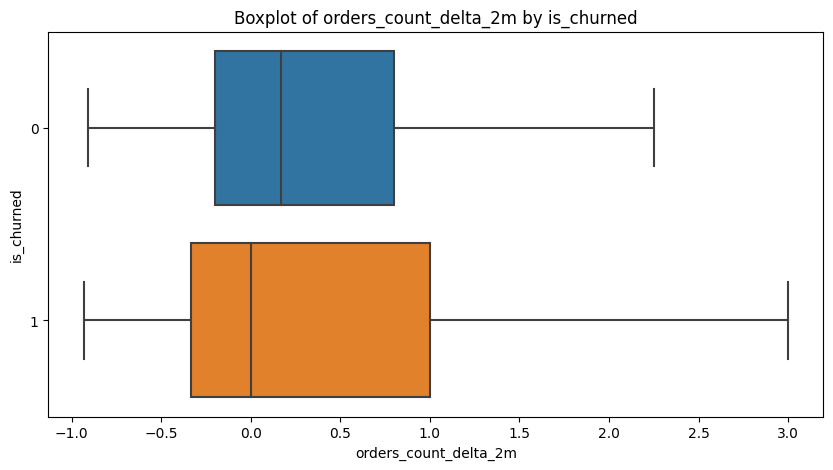

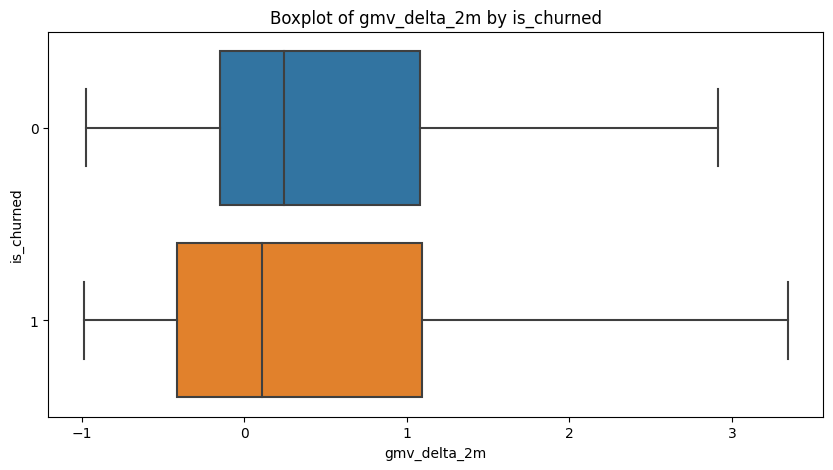

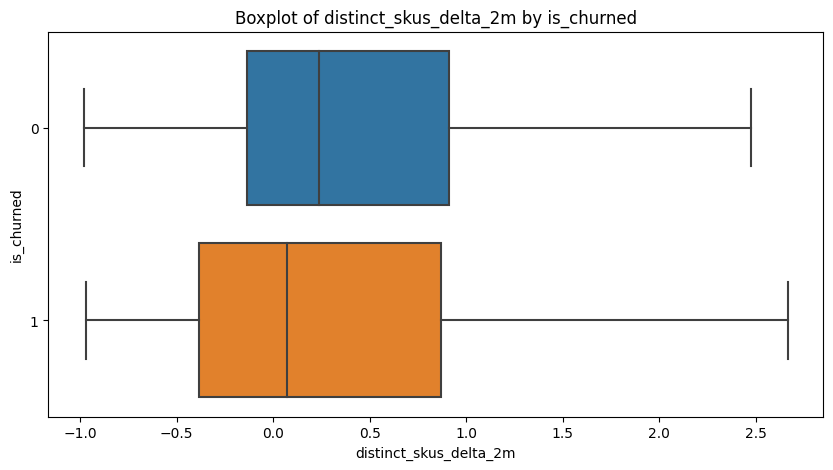

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract numerical columns
numerical_cols = df_reduction.drop(columns=['warehouse_Bogota', 'sub_categoria_Ambientadores', 'sub_categoria_Complementos y vitaminas', 'is_churned']).columns.tolist()

# Plot horizontal boxplot for each numerical column vs is_churned
for col in numerical_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=col, y="is_churned", data=df, orient="h", showfliers = False)
    plt.title(f'Boxplot of {col} by is_churned')
    plt.show()

## variables categoricas vs is_churned

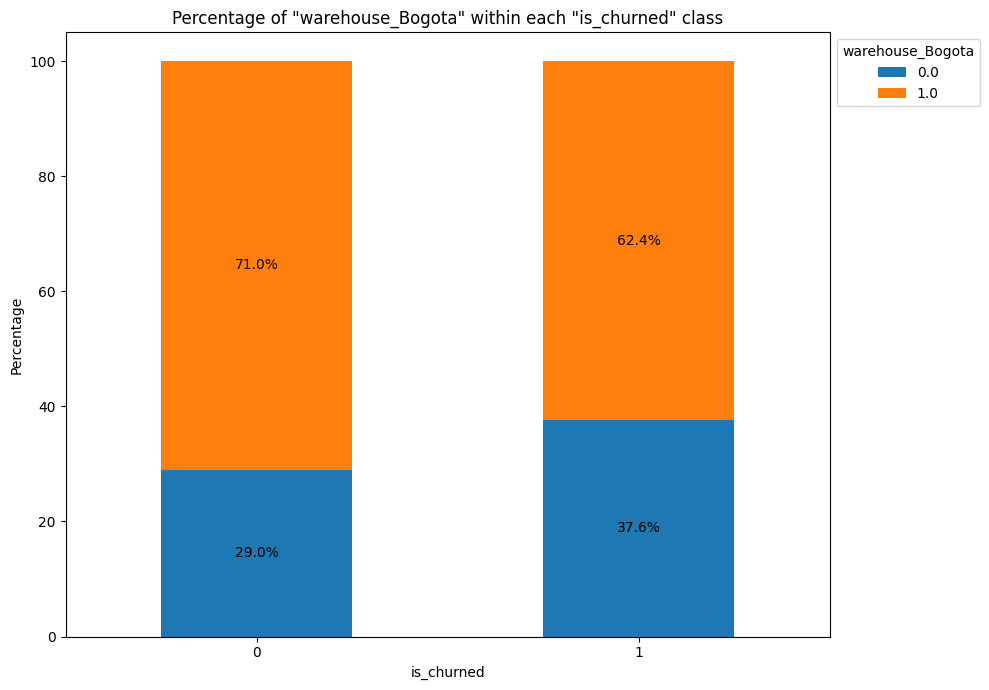

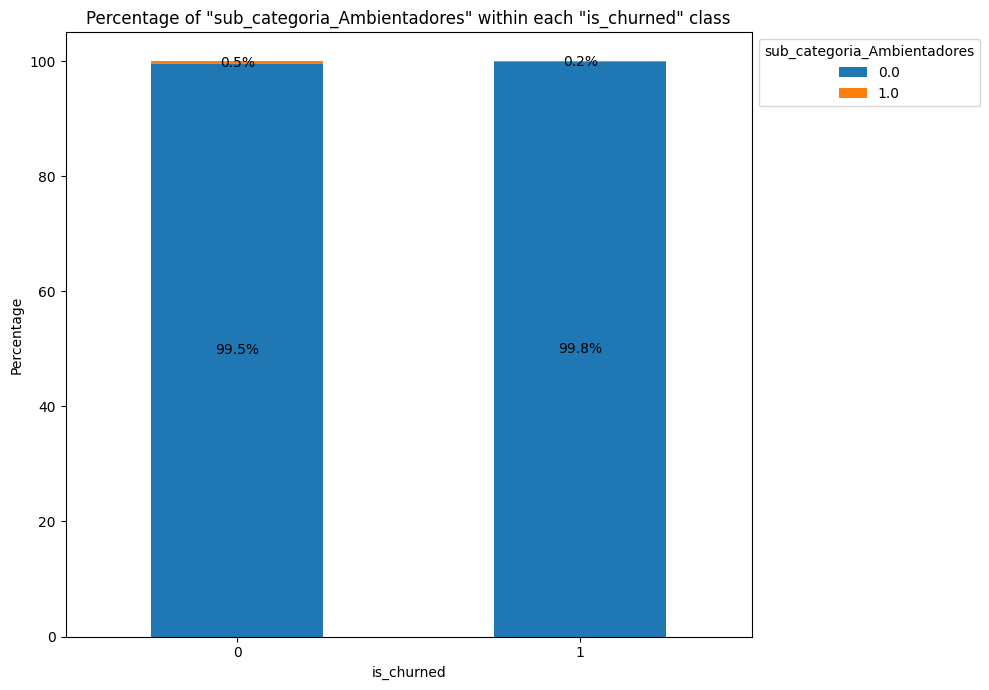

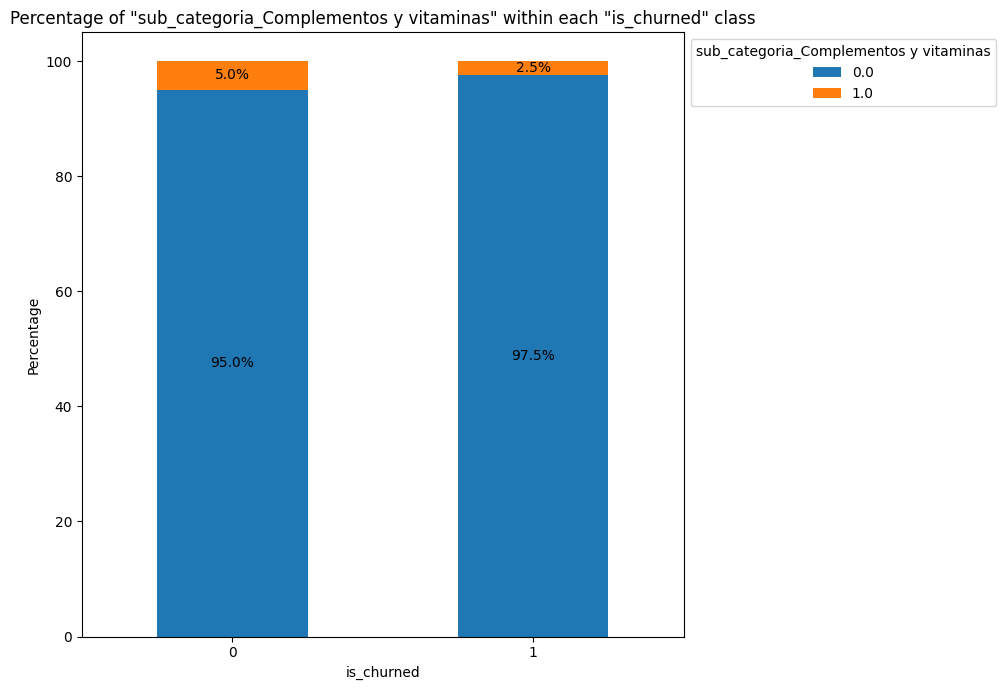

In [26]:
def compare_with_is_churned(df, variable):
    # Pivot table to get the counts
    pivot_table = df.groupby(['is_churned', variable]).size().unstack().fillna(0)

    # Calculate the percentages
    pivot_table_percentage = pivot_table.divide(pivot_table.sum(axis=1), axis=0) * 100

    # Plot
    ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(10, 7))
    plt.title(f'Percentage of "{variable}" within each "is_churned" class')
    plt.ylabel('Percentage')
    plt.xticks(rotation=0)
    plt.legend(title=variable, loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    # Annotate the percentages on the bars
    for n, x in enumerate([0, 1]): # Assuming 'is_churned' has two classes, 0 and 1
        for (percentage, y) in zip(pivot_table_percentage.loc[x], pivot_table_percentage.loc[x].cumsum()):
            ax.text(n, y - (percentage / 2), f'{percentage:.1f}%', ha='center', va='center')

    plt.show()

# Iterate over all columns except 'is_churned'
for column in ['warehouse_Bogota', 'sub_categoria_Ambientadores', 'sub_categoria_Complementos y vitaminas']:
    if column != 'is_churned':
        compare_with_is_churned(df_reduction, column)